In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)



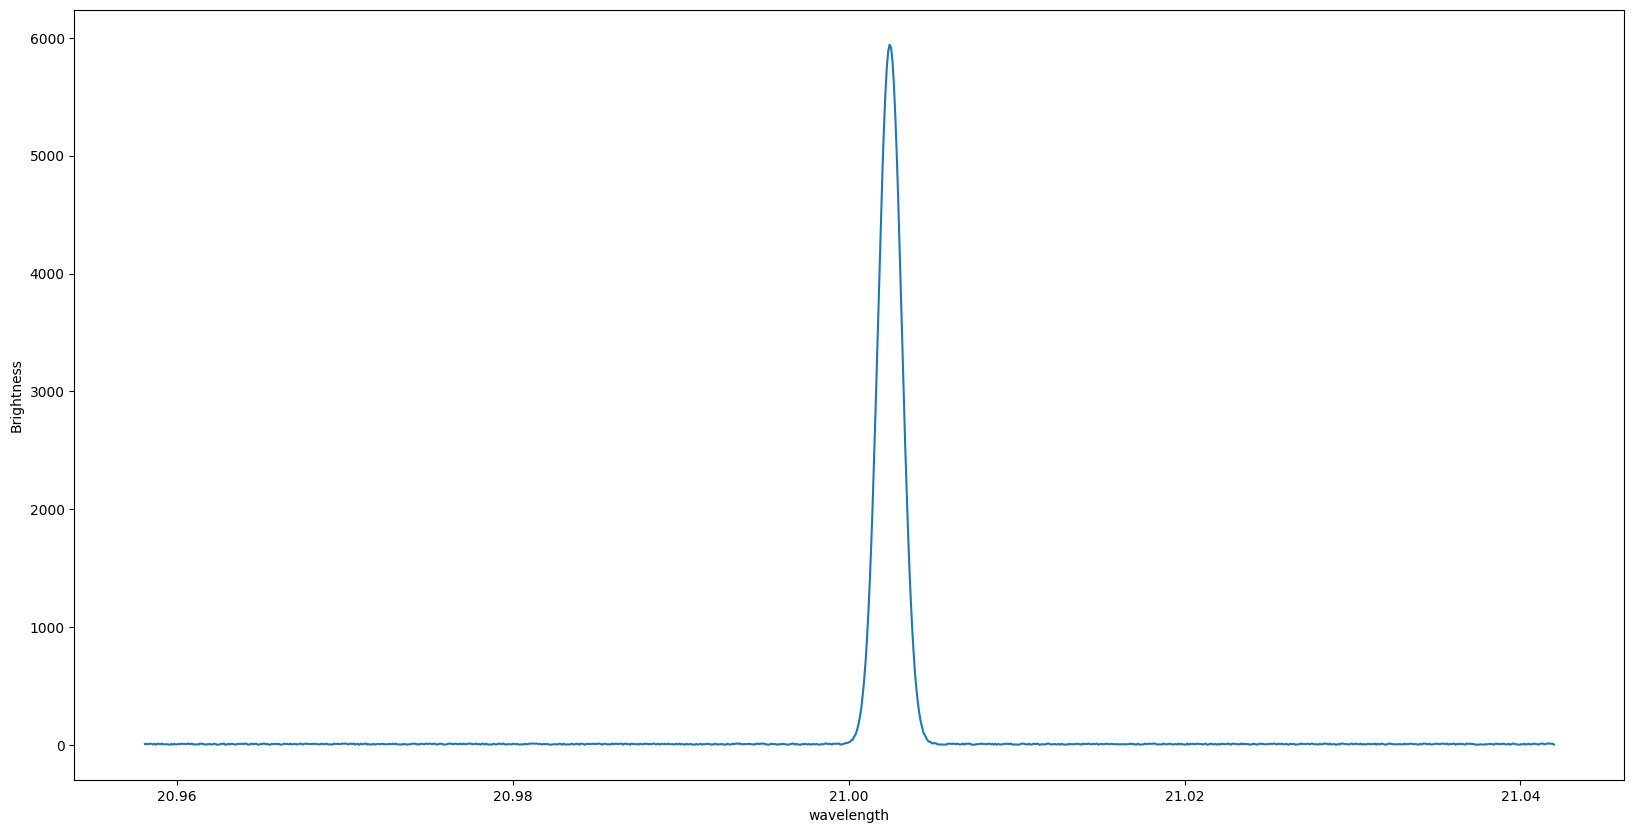

In [3]:
df = pd.read_table("/home/mehul/RadioKSP/Week2/spectrum_d_0.69_kpc.txt",delimiter = " ")
arr = df.to_numpy()

wavelength = []
brightness = []

for i in arr:
#     if(i[0]>20.99 and i[0]<21.01 and i[1] > 1000):
        wavelength.append(i[0])
        brightness.append(i[1])


wavelength = np.array(wavelength)
brightness = np.array(brightness)

plt.plot(wavelength,brightness)
plt.xlabel('wavelength')
plt.ylabel("Brightness")
plt.show()

In [4]:
def model(theta, wavelength = wavelength):
    central,A,sigma = theta
    return A*(1/(np.sqrt(2*np.pi)*sigma))*np.exp((-(wavelength-central)**2)/(2*sigma**2))

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

def lnprior(theta):
    central,A,sigma = theta
    if 5<A < 12 and 0 < sigma < 10**(-2) and 20.95<central<21.05:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

brr = 0.05*np.mean(wavelength)
data = (wavelength, brightness,brr)
nwalkers = 128
niter = 500
initial = np.array([21,10,10**(-4)])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]



def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)



def plotter(sampler,wavelength=wavelength,brightness=brightness):
    plt.ion()
    plt.plot(wavelength,brightness,label='Change in brightness')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(wavelength, model(theta, wavelength), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('wavelength in centimeters')
    plt.ylabel("brightness")
    plt.legend()
    plt.show()




Running burn-in...
Running production...


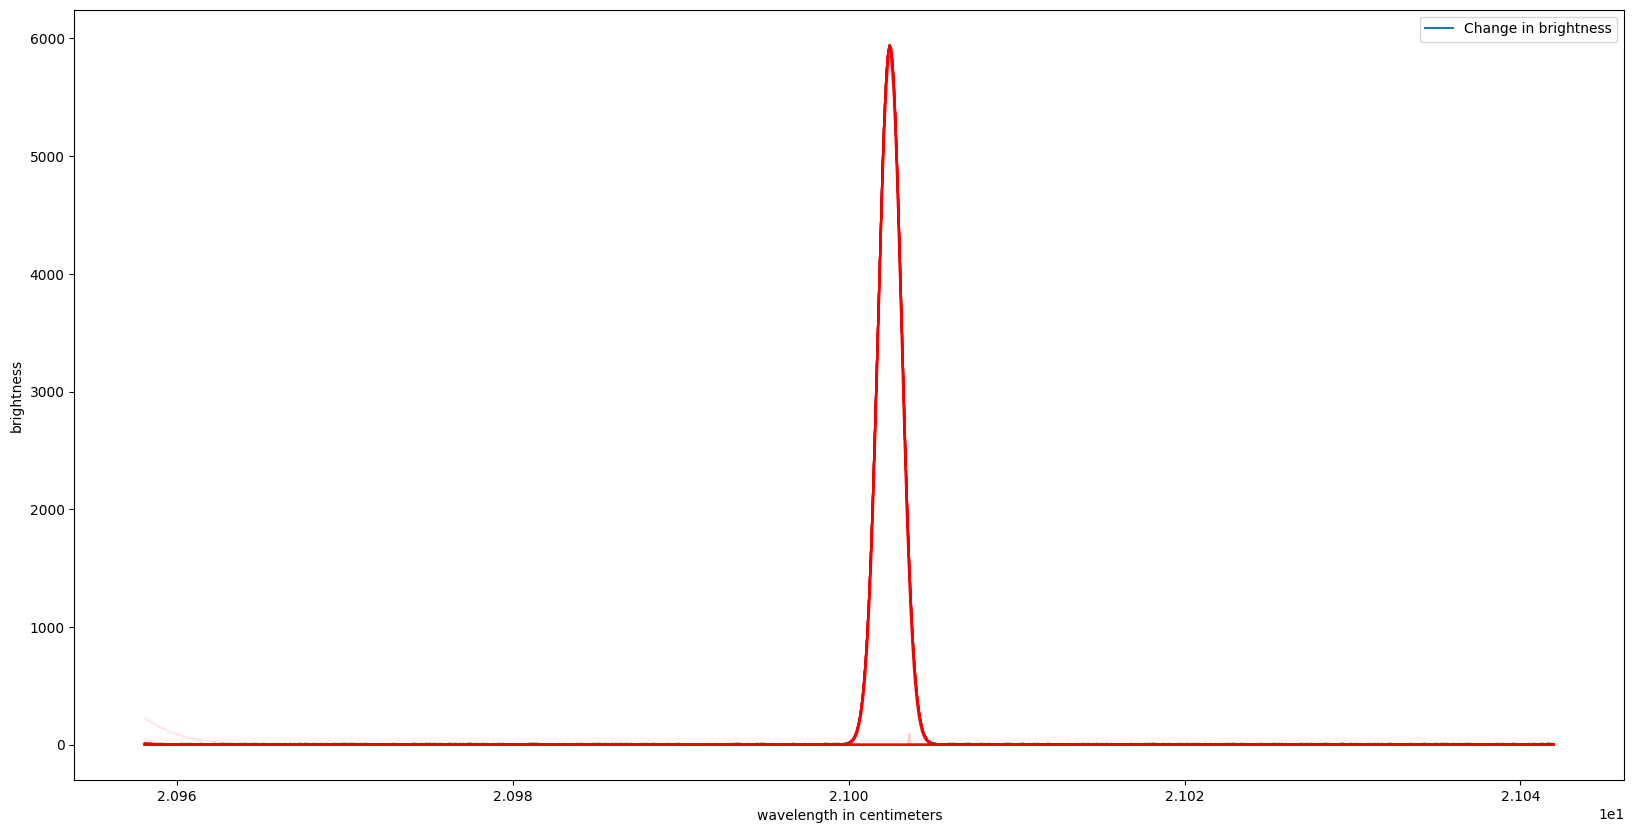

In [5]:
plotter(sampler)

In [6]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([2.10024518e+01, 1.04474149e+01, 7.01352040e-04])

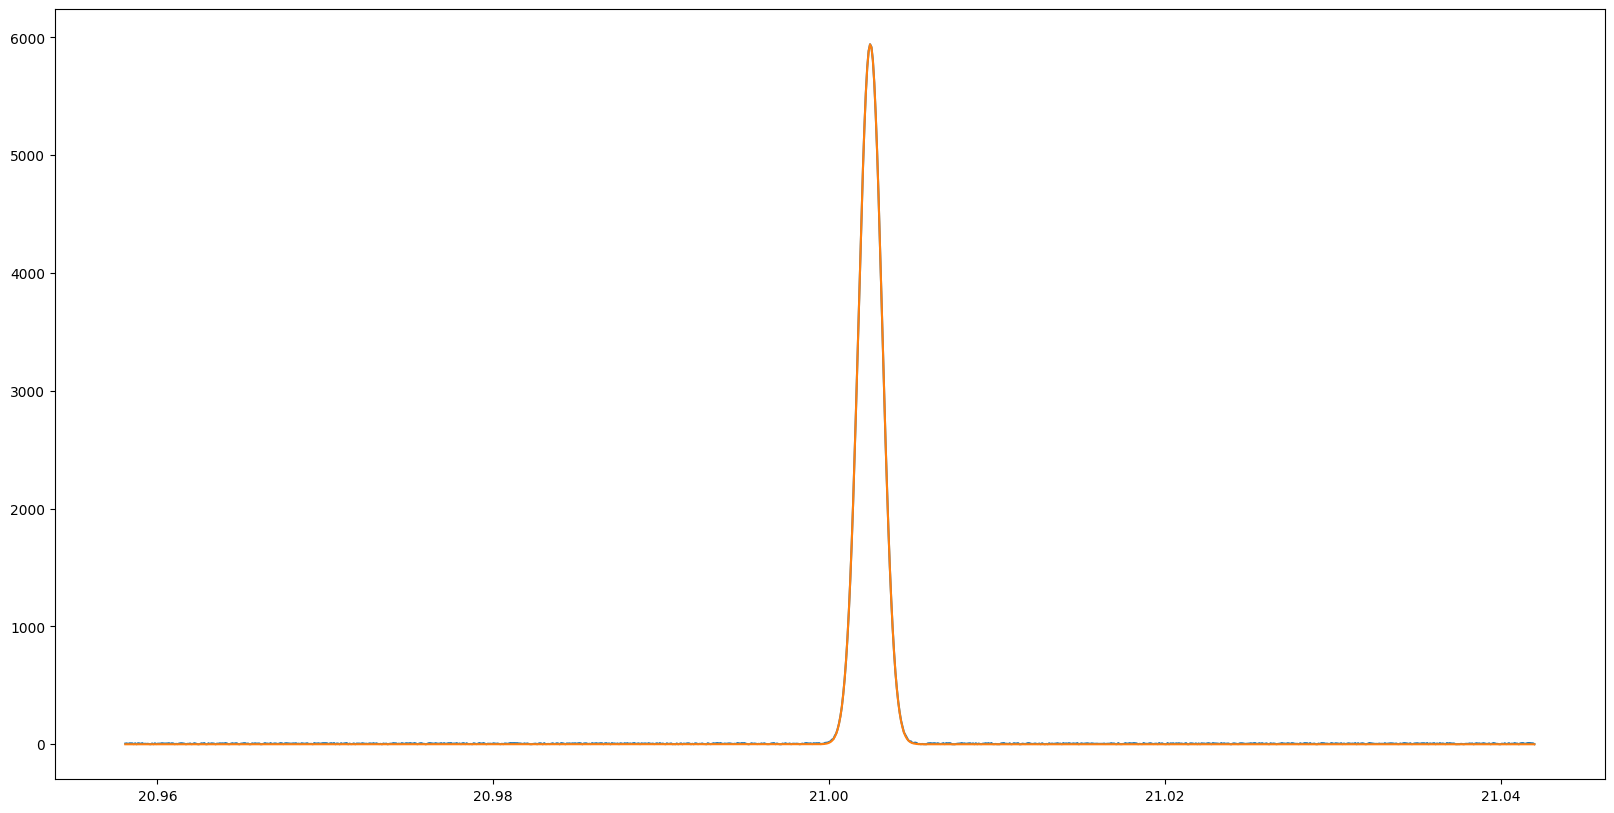

Theta max:  [2.10024518e+01 1.04474149e+01 7.01352040e-04]


In [7]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(wavelength,brightness,label='Change in brightness')
plt.plot(wavelength,best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',theta_max)


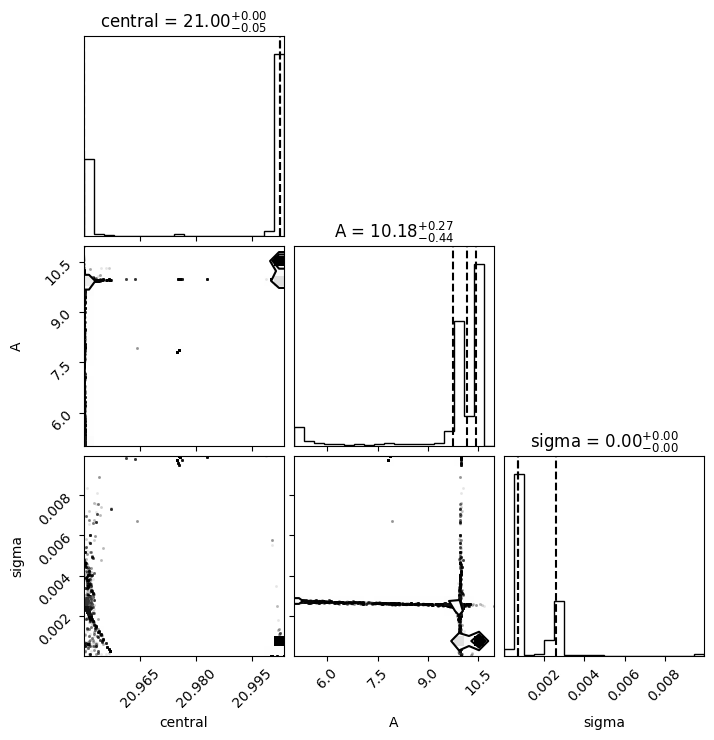

In [8]:
labels = ['central','A','sigma']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
